In [108]:
library(BGVAR) #load library
library(ggplot2)
library(zoo)
library(janitor) #rowtonames function


Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test




## Load Data

In [89]:
# Read in the data files
df_covid = read.csv('../../data/tidy/cases_deaths_concat.csv')
df_google = read.csv('../../data/tidy/google_activity.csv')
df_interv = read.csv('../../data/tidy/govt_interventions.csv')
#df_deter = read.csv('../../data/tidy/deterministic', row.names = 1 )

In [90]:
# Here, we make all the names uniform
# Ideally, this should be done in the preprocessing script in python (make this a TODO)
names(df_covid)[3:231] <- gsub(x = names(df_covid)[3:231], pattern = "X", replacement = "")
names(df_google)[3:231] = names(df_covid)[3:231]
names(df_interv)[3:231] = names(df_covid)[3:231]
df_covid = cbind(df_covid[['iso']], df_covid[['X']], df_covid[,3:231]) #reorder ISO and Variable columns

In [91]:
# Change the variable names to be shorter
# As I suggested, come up with 3- or 4-letter abbreviations for ALL the variables 
# Save these new names in the Python pre-processing script. Once this is done, the next few lines should be obsolete
df_interv$category <- gsub(x = df_interv$category, pattern = "Public health measures", replacement = "phm")
df_interv$category <- gsub(x = df_interv$category, pattern = "Governance and socio-economic measures", replacement = "sem")
df_interv$category <- gsub(x = df_interv$category, pattern = "Social distancing", replacement = "sd")
df_interv$category <- gsub(x = df_interv$category, pattern = "Movement restrictions", replacement = "mr")
df_interv$category <- gsub(x = df_interv$category, pattern = "Lockdown", replacement = "ld")
df_interv$category <- gsub(x = df_interv$category, pattern = "Humanitarian exemption", replacement = "he")

In [92]:
head(df_google) #check structure here to ensure uniformity

,iso,activity,2.15.2020,2.16.2020,2.17.2020,2.18.2020,2.19.2020,2.20.2020,2.21.2020,2.22.2020,⋯,9.27.2020,9.28.2020,9.29.2020,9.30.2020,X2020.10.01,X2020.10.02,X2020.10.03,X2020.10.04,X2020.10.05,X2020.10.06
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ABW,grocery,3,-9,-1,-5,-8,-1,9,10,⋯,-8,-8,-8,-6,-2,2,-5,-5,-3,-8
2,ABW,parks,12,4,16,8,3,0,9,-4,⋯,10,17,8,0,1,10,-13,4,17,11
3,ABW,residential,-2,0,6,4,4,1,1,0,⋯,9,12,11,9,8,10,12,6,9,10
4,ABW,retail,2,-1,-1,-2,1,4,7,-2,⋯,-31,-24,-24,-21,-20,-18,-31,-25,-19,-21
5,ABW,transit,26,1,-4,2,4,29,1,13,⋯,-59,-56,-49,-47,-51,-48,-65,-59,-52,-54
6,ABW,workplaces,-2,-1,-20,-13,-14,-13,-15,-6,⋯,-22,-21,-19,-19,-18,-23,-23,-20,-28,-26


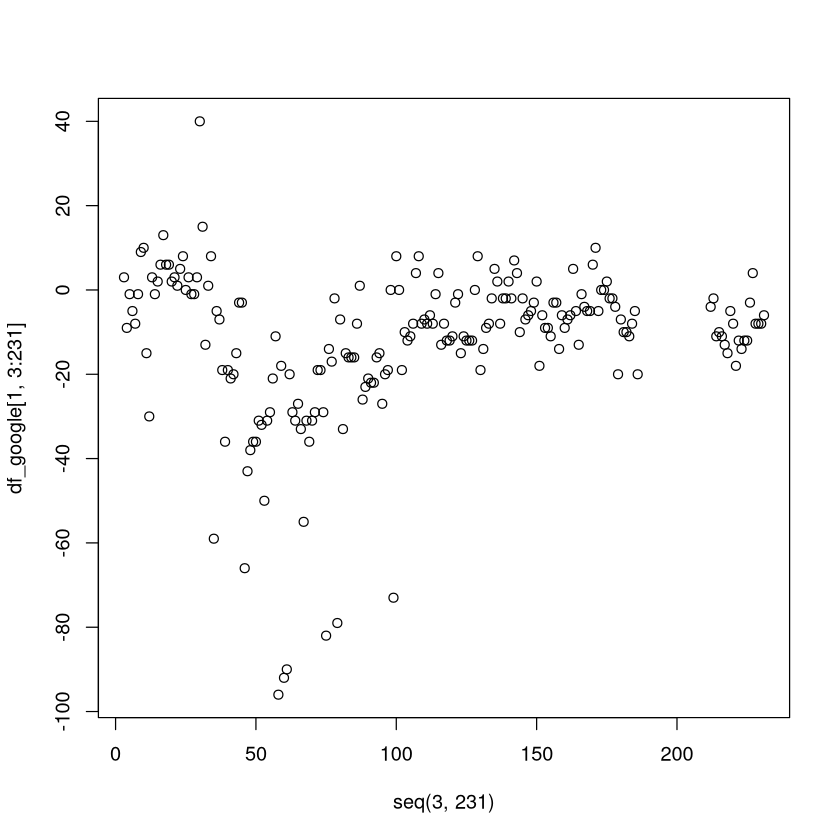

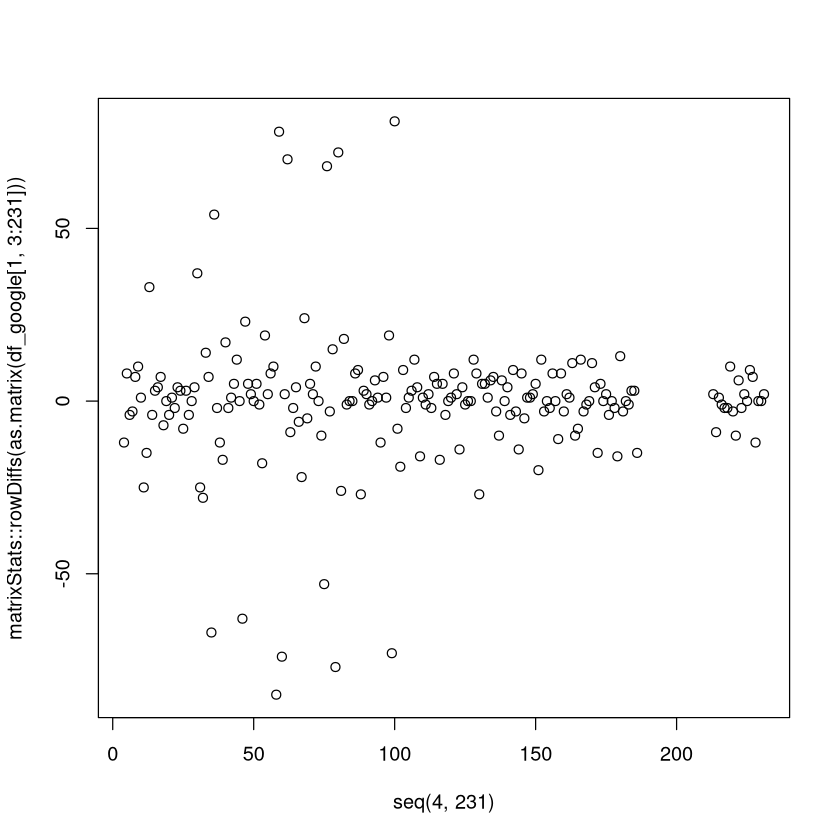

In [93]:
plot(seq(3,231),df_google[1,3:231]) #quick exploratory plotting
plot(seq(4,231),matrixStats::rowDiffs(as.matrix(df_google[1,3:231]))) #quick exploratory plotting

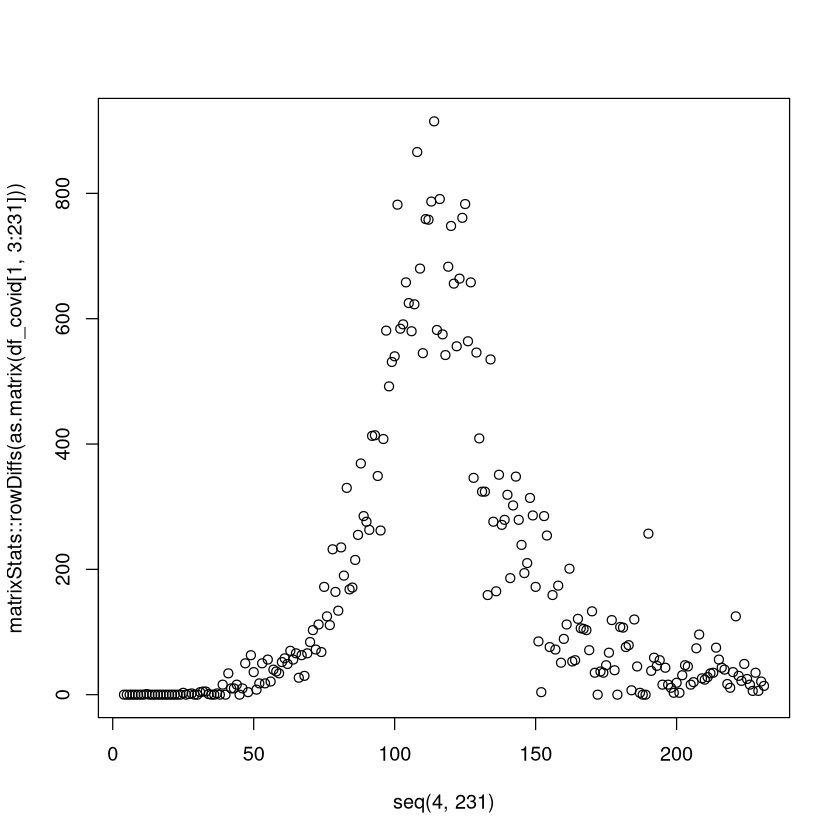

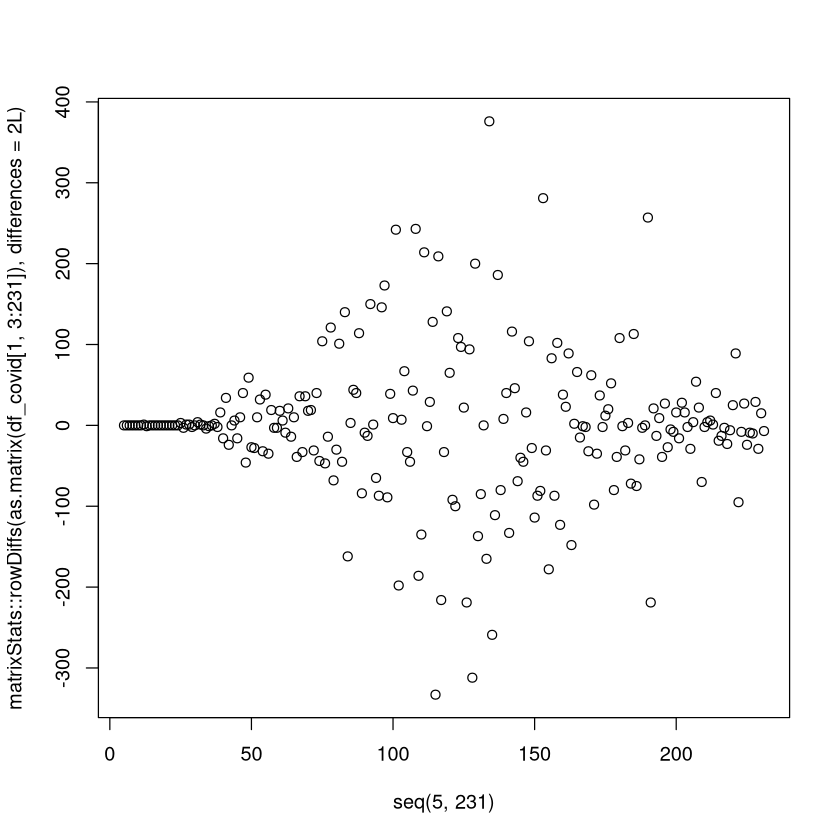

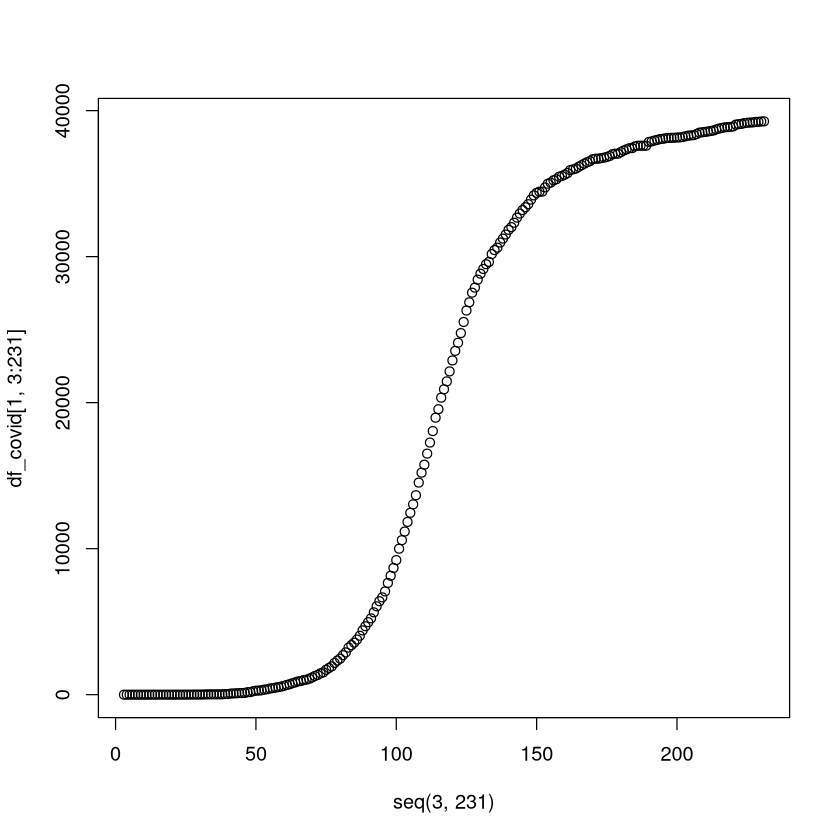

In [94]:
plot(seq(4,231),matrixStats::rowDiffs(as.matrix(df_covid[1,3:231]))) #quick exploratory plotting
plot(seq(5,231),matrixStats::rowDiffs(as.matrix(df_covid[1,3:231]), differences=2L)) # twice differenced
plot(seq(3,231),df_covid[1,3:231]) #quick exploratory plotting

In [95]:
df_covid[, 5:231] = matrixStats::rowDiffs(as.matrix(df_covid[, 3:231]), differences=2L) # convert to daily cases and then difference
df_google[, 4:231] = matrixStats::rowDiffs(as.matrix(df_google[, 3:231])) # 1st difference of google activity/mobility
# More data transformations can/may need to be done here. 

In [96]:
#Standardize names of first 2 columns (This can/should also be done in python pre-processing script)
names(df_covid)[1:2] = c('country', 'variable')
names(df_google)[1:2] = c('country', 'variable')
names(df_interv)[1:2] = c('country', 'variable')

In [127]:
length(unique(df_google$country))

[1] 121

In [98]:
df_endo <- rbind(df_covid[,1:231], df_google[,1:231]) #endogenous variables
df_exo <- df_interv[,1:231] #strictly exogenous variables

### Convert endogenous data into list of matrices

In [120]:
#Convert endogenous data into list of dataframes; each list element corresponds to country
# For each country, rows = time obs; columns = endogenous variables
endo = list()
for (i in unique(df_endo$country)) {
    country_df = janitor::row_to_names(t(df_endo[df_endo$country==i, 2:231]), 1)
    rownames(country_df) <- c()
  #head(b_df)
  endo[[i]] <- country_df 
}

### Convert exogenous data into list of matrices

In [121]:
exo = list()
for (i in unique(df_exo$country)) {
    country_df = janitor::row_to_names(t(df_exo[df_exo$country==i, 2:231]), 1)
    rownames(country_df) <- c()
  #head(b_df)
  exo[[i]] <- country_df 
}

In [125]:
unique(df_endo$country)

[1] "AFG" "AGO" "ALB" "AND" "ARE" "ARG" "ARM" "ATG" "AUS" "AUT" "AZE" "BDI"
 [13] "BEL" "BEN" "BFA" "BGD" "BGR" "BHR" "BHS" "BIH" "BLR" "BLZ" "BOL" "BRA"
 [25] "BRB" "BTN" "BWA" "CAF" "CAN" "CHE" "CHL" "CHN" "CIV" "CMR" "COL" "COM"
 [37] "CRI" "CUB" "CYP" "CZE" "DEU" "DJI" "DMA" "DNK" "DOM" "DZA" "ECU" "EGY"
 [49] "ERI" "ESH" "ESP" "EST" "ETH" "FIN" "FJI" "FRA" "GAB" "GBR" "GEO" "GHA"
 [61] "GIN" "GMB" "GNB" "GNQ" "GRC" "GRD" "GTM" "GUY" "HND" "HRV" "HTI" "HUN"
 [73] "IDN" "IND" "IRL" "IRQ" "ISL" "ISR" "ITA" "JAM" "JOR" "JPN" "KEN" "KGZ"
 [85] "KHM" "KWT" "LBN" "LBR" "LCA" "LIE" "LKA" "LSO" "LTU" "LUX" "LVA" "MAR"
 [97] "MCO" "MDG" "MDV" "MEX" "MLI" "MLT" "MNE" "MNG" "MOZ" "MRT" "MUS" "MWI"
[109] "MYS" "NAM" "NER" "NGA" "NIC" "NLD" "NOR" "NPL" "NZL" "OMN" "PAK" "PAN"
[121] "PER" "PHL" "PNG" "POL" "PRT" "PRY" "QAT" "ROU" "RWA" "SAU" "SDN" "SEN"
[133] "SGP" "SLE" "SLV" "SMR" "SOM" "SSD" "STP" "SUR" "SVK" "SVN" "SWE" "SYC"
[145] "TCD" "TGO" "THA" "TJK" "TLS" "TTO" "TUN" "TUR" "UGA" "UKR" "URY" "UZB"
[157] "VCT" "VEN" "VNM" "YEM" "ZAF" "ZMB" "ZWE" "SLB" "ABW" "CPV" "HKG" "PRI"
[169] "USA"

In [117]:
# Create uniform weight matrix (static in the current implementation)
bW = data.frame(matrix(0, ncol = length(endo), nrow = length(endo)))
rownames(bW) = names(endo)
colnames(bW) = names(endo)
for ( i in seq(1, length(endo))) {
  for (j in seq(1, length(endo))) {
    if (i != j) {
      #print(c(i,j))
      bW[i,j] = 1.0/(length(endo) - 1)
    }
  }
}

# Check weight matrix structure
all(colnames(bW)==names(endo)[1:(length(endo)-1)])
rowSums(bW)
diag(as.matrix(bW))
bW = as.matrix(bW)

# convert matrix into list as required
bWlist <- list()
for (i in colnames(bW)) {
  w_df <- data.frame(bW[,c(i)])
  colnames(w_df) <- i
  rownames(w_df) <- rownames(bW)
  bWlist[[i]] <- w_df
}

Warning message in colnames(bW) == names(endo)[1:(length(endo) - 1)]:
“longer object length is not a multiple of shorter object length”


[1] FALSE

AFG AGO ALB AND ARE ARG ARM ATG AUS AUT AZE BDI BEL BEN BFA BGD BGR BHR BHS BIH 
  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 
BLR BLZ BOL BRA BRB BTN BWA CAF CAN CHE CHL CHN CIV CMR COL COM CRI CUB CYP CZE 
  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 
DEU DJI DMA DNK DOM DZA ECU EGY ERI ESH ESP EST ETH FIN FJI FRA GAB GBR GEO GHA 
  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 
GIN GMB GNB GNQ GRC GRD GTM GUY HND HRV HTI HUN IDN IND IRL IRQ ISL ISR ITA JAM 
  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 
JOR JPN KEN KGZ KHM KWT LBN LBR LCA LIE LKA LSO LTU LUX LVA MAR MCO MDG MDV MEX 
  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 
MLI MLT MNE MNG MOZ MRT MUS MWI MYS NAM NER NGA NIC NLD NOR NPL NZL OMN PAK PAN 
  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 
PER PHL PNG POL PRT PRY QAT ROU RWA SAU SDN SEN SGP SLE SLV SMR SOM SSD STP SUR 
  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 
SVK SVN SWE SYC TCD TGO THA TJK TLS TTO TUN TUR UGA UKR URY UZB VCT VEN VNM YEM 
  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 
ZAF ZMB ZWE SLB ABW CPV HKG PRI USA 
  1   1   1   1   1   1   1   1   1

AFG AGO ALB AND ARE ARG ARM ATG AUS AUT AZE BDI BEL BEN BFA BGD BGR BHR BHS BIH 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
BLR BLZ BOL BRA BRB BTN BWA CAF CAN CHE CHL CHN CIV CMR COL COM CRI CUB CYP CZE 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
DEU DJI DMA DNK DOM DZA ECU EGY ERI ESH ESP EST ETH FIN FJI FRA GAB GBR GEO GHA 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
GIN GMB GNB GNQ GRC GRD GTM GUY HND HRV HTI HUN IDN IND IRL IRQ ISL ISR ITA JAM 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
JOR JPN KEN KGZ KHM KWT LBN LBR LCA LIE LKA LSO LTU LUX LVA MAR MCO MDG MDV MEX 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
MLI MLT MNE MNG MOZ MRT MUS MWI MYS NAM NER NGA NIC NLD NOR NPL NZL OMN PAK PAN 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
PER PHL PNG POL PRT PRY QAT ROU RWA SAU SDN SEN SGP SLE SLV SMR SOM SSD STP SUR 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
SVK SVN SWE SYC TCD TGO THA TJK TLS TTO TUN TUR UGA UKR URY UZB VCT VEN VNM YEM 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
ZAF ZMB ZWE SLB ABW CPV HKG PRI USA 
  0   0   0   0   0   0   0   0   0

In [ ]:
## BGVAR
# SSVS prior
Hyperparm.ssvs <- list(tau0   = 0.1,  # coefficients: prior variance for the spike
                       # (tau0 << tau1)
                       tau1   = 3,    # coefficients: prior variance for the slab  
                       # (tau0 << tau1)
                       kappa0 = 0.1,  # covariances: prior variance for the spike 
                       # (kappa0 << kappa1)
                       kappa1 = 7,    # covariances: prior variance for the slab 
                       # (kappa0 << kappa1)
                       a_i    = 0.01, # prior for the shape parameter of the IG
                       b_i    = 0.01, # prior for the scale parameter of the IG
                       p_i    = 0.5,  # prior inclusion probability of coefficients
                       q_ij   = 0.5   # prior inclusion probability of covariances
)

model <- bgvar(Data = endo, #endogenous variables
               Ex = exo, #exogenous variables
               W = bWlist, #static weight matrix (use uniform weights)
               plag=7,
               saves=100, burns=100, prior="SSVS", SV=TRUE, hyperpara=Hyperparm.ssvs, 
               h = 292, #40% held out 
               thin = 1,
               variable.list=NULL,
               trend = FALSE,
               save.country.store=FALSE
)